# DenseNet in Tensorflow (Functional API)

This notebook implements a DenseNet architecture using the functional API. This should serve to help with understanding the computations involved without giving away the solution to the homework. You will need to translate this to the sub-classing API.

Recall the differences between the Functional API and the Sub-Classing API:

- In the functional API, you don't need an init in which we list all the layers that we will use

- In the subclassing API you need to define all the layers (and on a lower level the variables) that you use in the call method. Do not have excess layers in the init that you do not use in the call method.

- In the functional API, you can simply ignore the batch dimension in the operations that we do. Tensorflow/Keras take care of the batch dimension.

- In the subclassing API, you need to think about the batch dimension when writing the layers (especially important for concatenating two tensors within a layer).


In [5]:
import tensorflow as tf

In [6]:
def dense_block(x, n_filters, new_channels):
    
    """
    Instantiates the layers and computations involved in a a DenseBlock from DenseNet for the functional API.
    
    Args:
    x (KerasTensor) : Input to the block
    
    n_filters (int) : number of filters used within the block (does not have an effect on n of output channels)
    
    new_channels (int) : number of channels to be added to the input by the block
    """
    
    # batchnorm and relu
    x_out = tf.keras.layers.BatchNormalization()(x)
    x_out = tf.keras.layers.Activation(tf.nn.relu)(x_out)
    
    # 1x1 convolution with 128 filters (padding "valid" because with 1x1 we don't need padding)
    x_out = tf.keras.layers.Conv2D(n_filters, kernel_size=(1,1), padding="valid")(x_out)
    
    # batchnorm and relu
    x_out = tf.keras.layers.BatchNormalization()(x_out)
    x_out = tf.keras.layers.Activation(tf.nn.relu)(x_out)
    
    # 3x3 convolution with 32 filters (to be concatenated with the input)
    x_out = tf.keras.layers.Conv2D(new_channels, kernel_size=(3,3), padding="same")(x_out)
    
    
    # Concatenate layer (just a tf.keras.layers.Layer that calls tf.concat)
    x_out = tf.keras.layers.Concatenate(axis=-1)([x, x_out]) # axis -1 for channel dimension
    
    return x_out

In [7]:
# Define pseudo-input (this type of thing does not exist with sub-classing!)
x_in = tf.keras.layers.Input(shape= (32,32,3)) 

# have an initial Conv layer before the first res block (increasing the n of channels)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x_in)

# increases the number of channels by new_channels
x_out = dense_block(x, n_filters=128, new_channels=32)

# You can stack arbitrarily many of such dense blocks.
# x_out = dense_block(x_out, n_filters=256, new_channels=64) 

# x_out = dense_block(x_out, n_filters=128, new_channels=32)

model = tf.keras.Model(x_in, x_out)

In [8]:
# in the subclassing API, you need to call the model on an input before model.summary() works
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 32)   128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 32)   0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

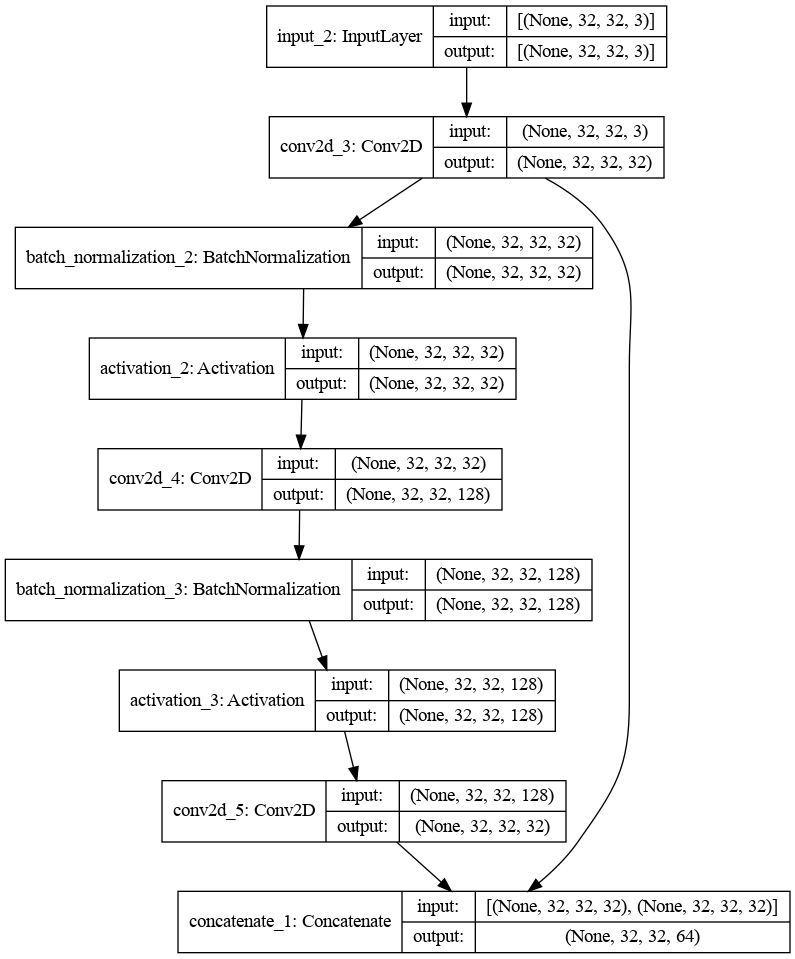

In [9]:
# plotting a model graph only works for functional API models
tf.keras.utils.plot_model(model, show_shapes=True)

# Task for homework: 

- Implement a DenseBlock similar to the above by subclassing tf.keras.layers.Layer and use it to build a model that uses this custom layer and is subclassed from tf.keras.Model with a custom train and validation loop